<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Here I've put together a quick benchmark using the MBQC dataset.

The idea here is that we select two sample names (that were processed by different groups), 
and compute the differentials between the sample names for each cohort.
If the different cohort agrees, this is a first step showcasing how differential abunance can help ignore batch effects.

It is important to note that this contingent on there being large batch effects in the first place.
Samples are deliberately chosen to showcase this.

In [1]:
import biom
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
%matplotlib inline

First we'll load the fitted models and the raw data.

In [2]:
data_dir = '../sfari/data/mbqc/'
schloss = az.from_netcdf(f'{data_dir}/schloss_posterior')
knight = az.from_netcdf(f'{data_dir}/knight_posterior')
flores = az.from_netcdf(f'{data_dir}/flores_posterior')
turnbaugh = az.from_netcdf(f'{data_dir}/turnbaugh_posterior')

table = biom.load_table(f'{data_dir}/deblur/all.wol.biom')
md = pd.read_table(f'{data_dir}/metadata/sample_14_61_metadata.txt', index_col=0)
# drop irrelevant features and samples
filter_f = lambda v, i, m: i in md.index
table.filter(filter_f, axis='sample')
taxa = table.ids(axis='observation')[table.sum(axis='observation') > 10]
md = md.loc[table.ids()]
md['Contributor_name'] = md['Contributor'].apply(lambda x: x.split('-')[0])

Then we'll visualize the samples via Bray-Curtis.

In [3]:
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity

tab = table.to_dataframe().T
ids = list(tab.index)
otu_ids = list(tab.columns)
dm = beta_diversity("braycurtis", tab.values, tab.index)
res = pcoa(dm)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1570417557472925 and the largest is 13.276194640205837.
  warn(


In [4]:
rmd = pd.concat((res.samples, md), axis=1)
select_contributors = ['Roberto Flores', 'Peter Turnbaugh', 'Robert Knight', 'Pat Schloss']
rmd = rmd.loc[rmd['Contributor_name'].apply(lambda x: x in select_contributors)]
rmd['Last_name'] = rmd['Contributor_name'].apply(lambda x: x.split(' ')[-1])

Text(0, 0.5, 'PC2')

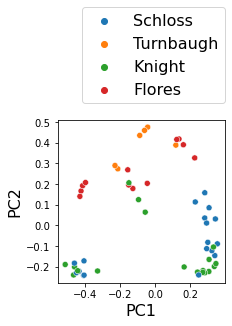

In [5]:
fig = plt.figure(figsize=(3, 3))
fs = 16
sns.scatterplot(data=rmd, x='PC1', y='PC2', hue='Last_name')
plt.legend(bbox_to_anchor=(1, 1.1), loc=4, borderaxespad=0., fontsize=fs)

plt.xlabel('PC1', fontsize=fs)
plt.ylabel('PC2', fontsize=fs)

Text(0, 0.5, 'PC2')

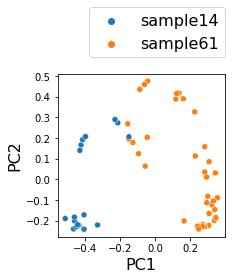

In [6]:
fig = plt.figure(figsize=(3, 3))
sns.scatterplot(data=rmd, x='PC1', y='PC2', hue='Sample_Name')
plt.legend(bbox_to_anchor=(1, 1.1), loc=4, borderaxespad=0., fontsize=fs)
ax = plt.gca()
fs = 16
ax.set_xlabel('PC1', fontsize=fs)
ax.set_ylabel('PC2', fontsize=fs)

Look!  There are batch effects!

Let's now create some helper functions to see what the actual differentials look like.

In [7]:
def posterior_to_dataframe(x):
    # convert model parameters into something readable
    df = x['posterior']['beta'].to_dataframe().reset_index()
    df = pd.pivot(df, index='feature', columns=['chain', 'draw'])
    return df

flores = posterior_to_dataframe(flores)
turnbaugh = posterior_to_dataframe(turnbaugh)
knight = posterior_to_dataframe(knight)
schloss = posterior_to_dataframe(schloss)

def nonzero_taxa(table, md, contributor, sample_names):
    # Drop taxa that aren't present
    zmd = md.loc[md['Contributor_name'].apply(lambda x: x == contributor)]
    zmd = zmd.loc[md['Sample_Name'].apply(lambda x: x in sample_names)]
    
    filter_f = lambda v, i, m: i in zmd.index
    subtable = table.filter(filter_f, axis='sample', inplace=False)
    taxa = subtable.ids(axis='observation')[subtable.sum(axis='observation') > 0]
    return taxa

We'll now enumerate all pairwise comparisons between differentials.

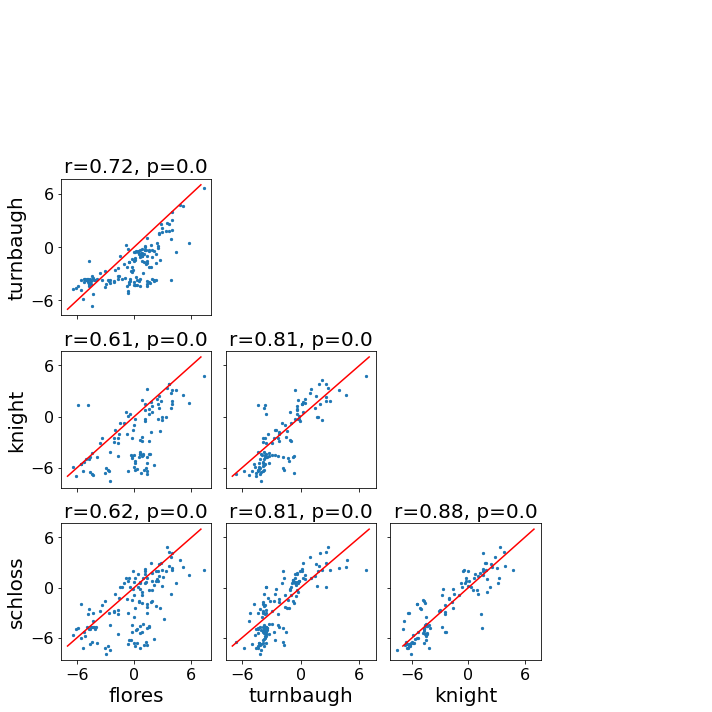

In [8]:
from matplotlib.ticker import MaxNLocator

names = ['Roberto Flores', 'Peter Turnbaugh', 'Robert Knight', 'Pat Schloss']
contribs = ['flores', 'turnbaugh', 'knight', 'schloss']

#names = ['Joseph Petrosino', 'Pat Schloss', 'Robert Knight', 'K Jones', 'Roberto Flores', 
#         'David Mills', 'Robert Burk', 'Peter Turnbaugh', 'Dan Littman', 'Greg Gloor', 
#         'Jacques Ravel', 'Andrew Goodman']
#contribs = ['petrosino', 'schloss', 'knight', 'jones', 'flores', 'mills',
#            'burk', 'turnbaugh', 'littman', 'gloor', 'ravel', 'goodman']
fs = 20
ls = 16
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(len(contribs)):
    for j in range(len(contribs)):
        if j >= i:
            ax[i][j].spines['top'].set_visible(False)
            ax[i][j].spines['right'].set_visible(False)
            ax[i][j].spines['bottom'].set_visible(False)
            ax[i][j].spines['left'].set_visible(False)
            ax[i][j].get_xaxis().set_ticks([])
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].axis('off')
            ax[i][j].patch.set_visible(False)
            ax[i][j].set(frame_on=False)
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])
        else:
            itaxa = nonzero_taxa(table, md, names[i], sample_names=['sample14', 'sample61'])
            jtaxa = nonzero_taxa(table, md, names[j], sample_names=['sample14', 'sample61'])
            common_taxa = list(set(itaxa) & set(jtaxa))
            # drop taxa with zero counts
            r, p = pearsonr(eval(contribs[i]).mean(axis=1).loc[common_taxa], 
                            eval(contribs[j]).mean(axis=1).loc[common_taxa])
            ax[i][j].scatter(eval(contribs[j]).mean(axis=1).loc[common_taxa], 
                             eval(contribs[i]).mean(axis=1).loc[common_taxa], s=5)
            ax[i][j].set_xlabel(contribs[j], fontsize=fs)
            ax[i][j].set_ylabel(contribs[i], fontsize=fs)
            r, p = np.round(r, 2), np.round(p, 2)
            ax[i][j].set_title(f'r={r}, p={p}', fontsize=fs)
            ix = np.linspace(-7, 7)
            ax[i][j].plot(ix, ix, c='r')
            
            locator=MaxNLocator(prune='both', nbins=3)
            ax[i][j].yaxis.set_major_locator(locator)
            ax[i][j].xaxis.set_major_locator(locator)
            ax[i][j].tick_params(axis='x', labelsize=ls)
            ax[i][j].tick_params(axis='y', labelsize=ls)

            if i != 3:
                ax[i][j].set_xlabel('')
                ax[i][j].set_xticklabels([])
            if j != 0:
                ax[i][j].set_ylabel('')
                ax[i][j].set_yticklabels([])

        #plt.show()
plt.tight_layout()

B